In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [63]:
time = pd.date_range('2021-01-01', freq="D", periods=356*3)

holiday = calendar().holidays(start=time.min(), end=time.max(), return_name=True)
holiday = pd.get_dummies(holiday, drop_first=False).astype(int)
df = pd.DataFrame(index=time)
holiday_df = df.join(holiday).fillna(0)
holiday_df = holiday_df.resample("W-MON").sum()
t = np.linspace(0, 6*np.pi, len(holiday_df))
betas_holiday_direct = np.random.normal(0, 4, size=len(holiday_df.columns))*np.random.binomial(1, 0.2, size=len(holiday_df.columns))
betas_holiday_indirect = np.random.normal(0, 4, size=len(holiday_df.columns))*np.random.binomial(1, 0.2, size=len(holiday_df.columns)) + betas_holiday_direct
season = np.sin(t) + .3*np.sin(2*t)
season = season/season.max()
holiday_effect = holiday_df.values.dot(betas_holiday_direct)
indirect_holiday_effect = holiday_df.values.dot(betas_holiday_indirect)

category = season + indirect_holiday_effect + np.random.normal(0, .2, size=len(holiday_df))
treatment = season + np.random.normal(0, 1, size=len(holiday_df)) + holiday_effect*.5
y = 2*season + holiday_effect + 2*treatment + category + np.random.normal(0, .1, size=len(holiday_df))


In [64]:
data = holiday_df.copy()
#data["season"] = season
data["category"] = category
data['treatment'] = treatment
#data['sin1'] = np.sin(t)
#data['sin2'] = np.sin(2*t)
#data['sin3'] = np.sin(3*t)
full_data = data.copy()
full_data['target'] = y
#data = data.drop(columns=['Thanksgiving Day'])
with pm.Model(coords={'IVS': data.columns}) as model:
    betas = pm.Normal("betas", 0, 10, dims=("IVS",))
    y_hat = pm.math.dot(data.values, betas)
    sigma = pm.Exponential("sigma", 1)
    likelihood = pm.Normal("likelihood", y_hat, sigma, observed=y)
    trace = pm.sample(2000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


In [65]:
pd.DataFrame(data=betas_holiday_direct[None, :], columns=holiday_df.columns)

,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Juneteenth National Independence Day,Labor Day,Memorial Day,New Year's Day,Thanksgiving Day,Veterans Day,Washington's Birthday
0,-0.0,-0.0,0.0,0.0,0.0,-0.13132,-0.0,3.167538,-0.0,3.115133,2.487265


In [66]:
pd.DataFrame(data=betas_holiday_indirect[None, :], columns=holiday_df.columns)

,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Juneteenth National Independence Day,Labor Day,Memorial Day,New Year's Day,Thanksgiving Day,Veterans Day,Washington's Birthday
0,-0.0,0.0,0.0,0.0,0.0,-0.13132,5.436678,7.658814,0.0,3.115133,2.487265


In [67]:
with model:

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [likelihood]


Output()

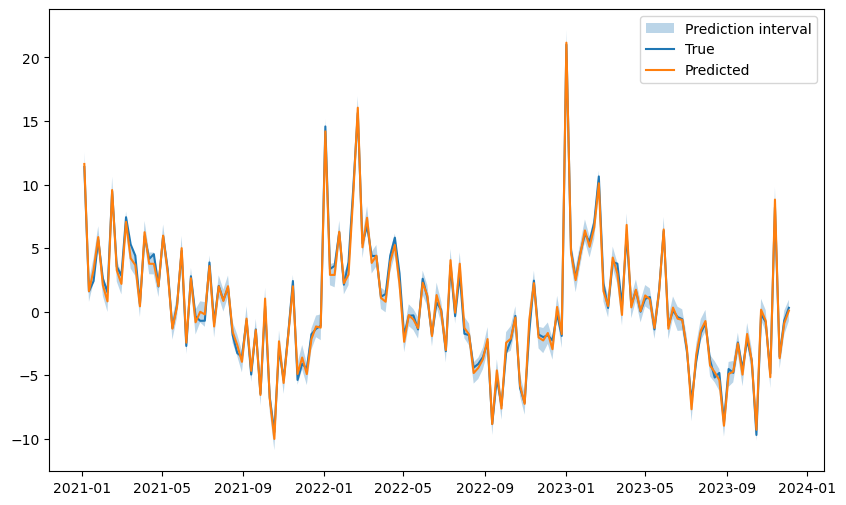

In [68]:
hdi = az.hdi(trace.posterior_predictive, hdi_prob=0.95)
fig = plt.figure(figsize=(10, 6))
plt.fill_between(data.index, hdi.sel(hdi='lower').to_array()[0], hdi.sel(hdi='higher').to_array()[0], alpha=0.3, label='Prediction interval')
plt.plot(data.index, y, label="True")
plt.plot(data.index, trace.posterior_predictive['likelihood'].mean(axis=(0,1)), label="Predicted")
plt.legend()

In [69]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[Birthday of Martin Luther King, Jr.]",0.065,0.252,-0.412,0.531,0.003,0.003,9137.0,5887.0,1.0
betas[Christmas Day],-0.095,0.306,-0.667,0.488,0.003,0.003,8166.0,6040.0,1.0
betas[Columbus Day],-0.486,0.254,-0.968,-0.012,0.003,0.002,8286.0,6006.0,1.0
betas[Independence Day],-0.173,0.250,-0.656,0.294,0.003,0.002,7865.0,6055.0,1.0
betas[Juneteenth National Independence Day],0.145,0.245,-0.333,0.589,0.003,0.002,8575.0,5964.0,1.0
betas[Labor Day],-0.411,0.250,-0.875,0.060,0.003,0.002,9382.0,6238.0,1.0
betas[Memorial Day],-8.866,0.422,-9.646,-8.074,0.007,0.005,3770.0,4822.0,1.0
betas[New Year's Day],-10.177,0.531,-11.205,-9.202,0.009,0.006,3718.0,4690.0,1.0
betas[Thanksgiving Day],-0.131,0.246,-0.599,0.339,0.003,0.002,7872.0,5973.0,1.0
betas[Veterans Day],-2.284,0.283,-2.816,-1.762,0.004,0.003,5309.0,6193.0,1.0


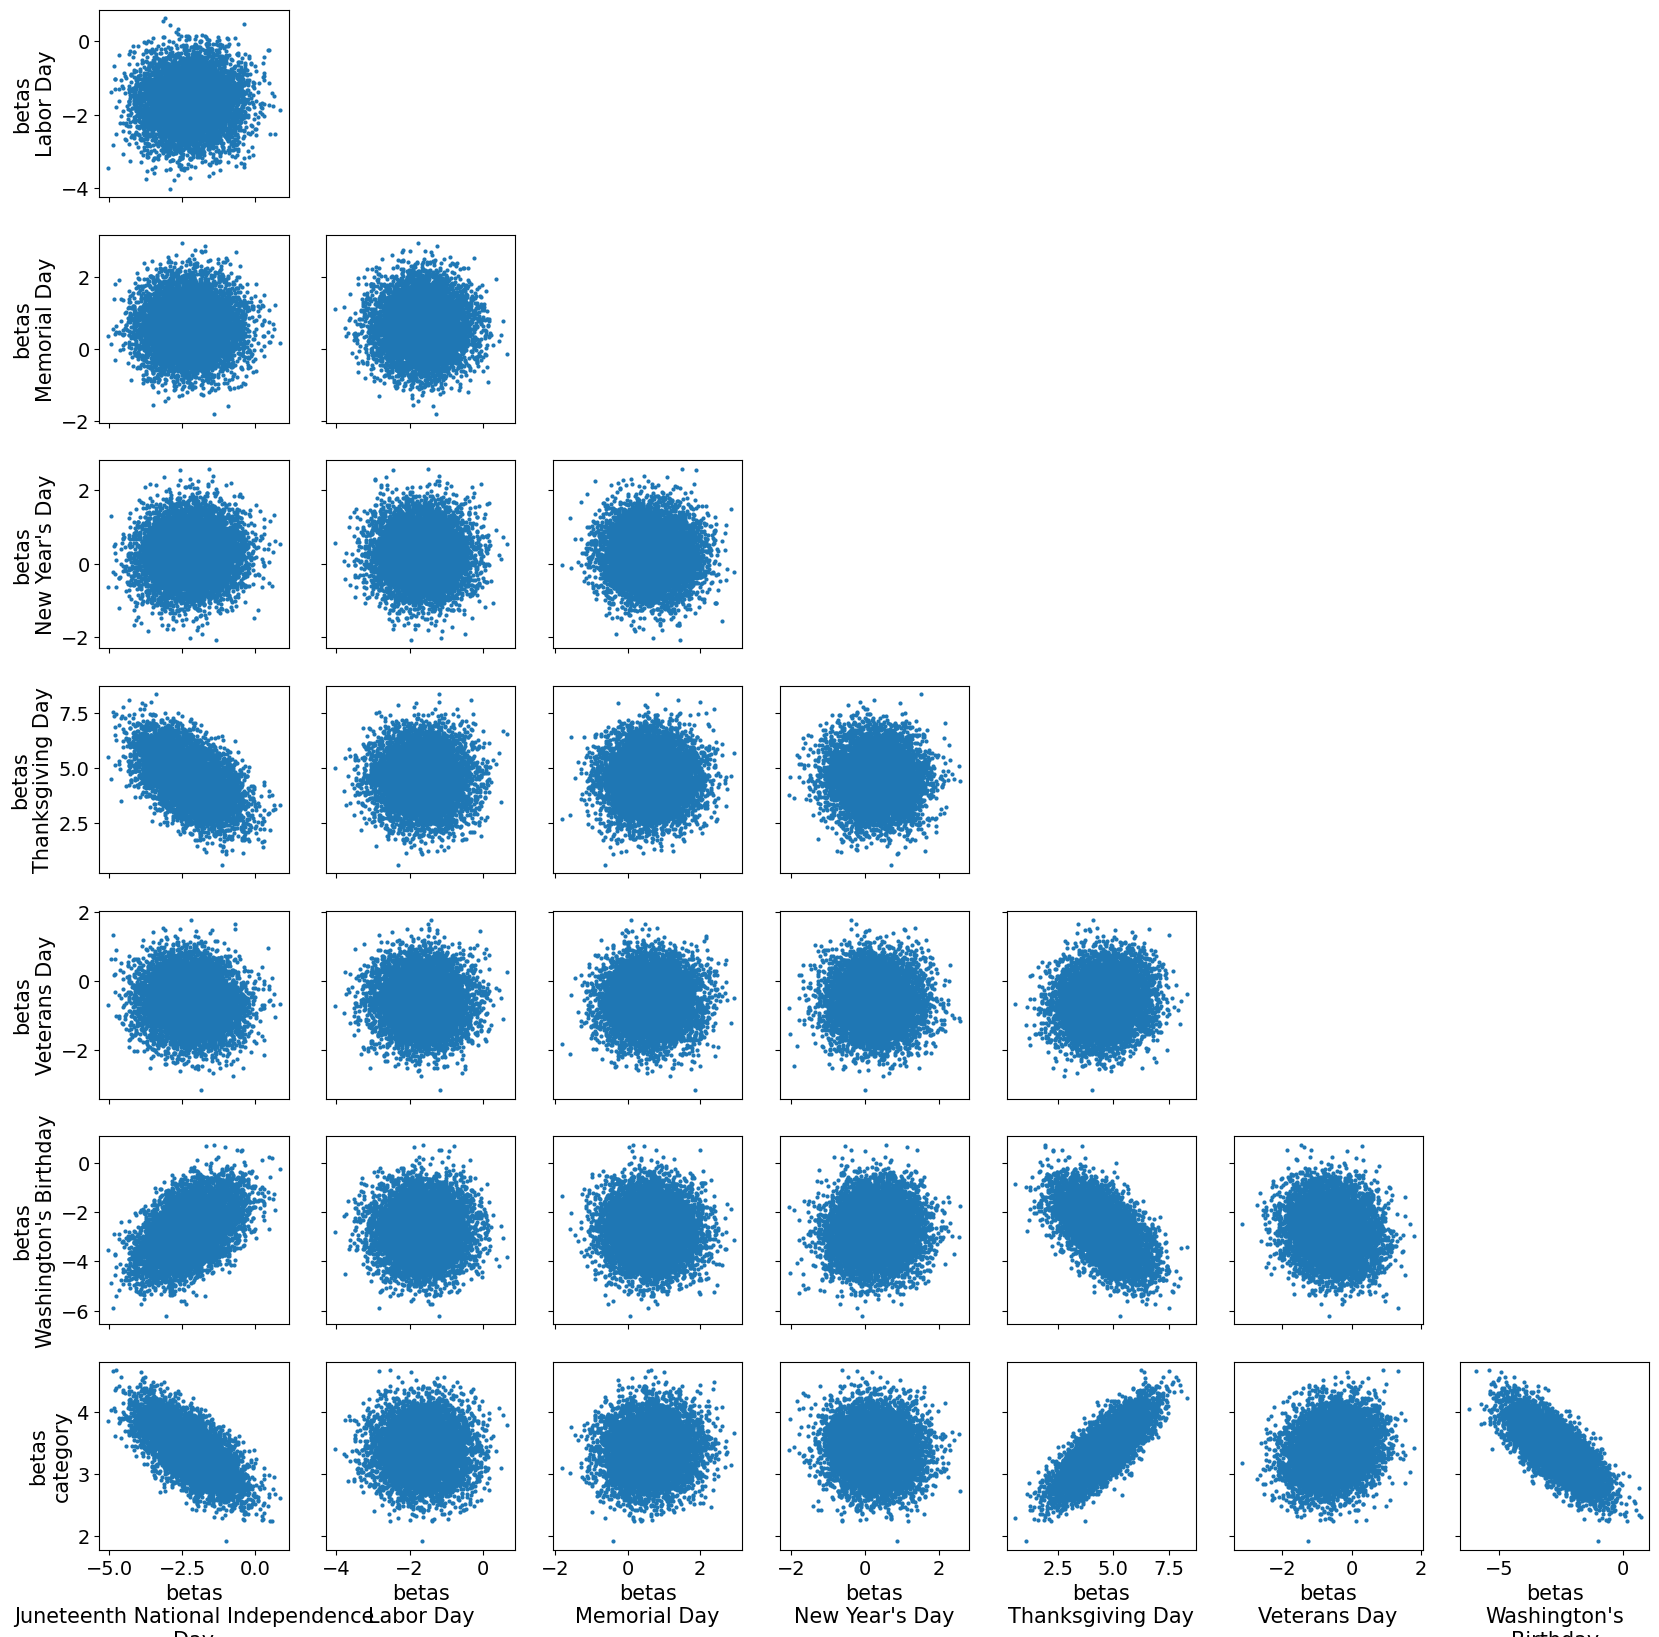

In [15]:
pm.plot_pair(trace, figsize=(20, 20), var_names=["betas"], coords={'IVS': data.columns[-8:]});

In [8]:
full_data.corr()

,"Birthday of Martin Luther King, Jr.",Christmas Day,Columbus Day,Independence Day,Juneteenth National Independence Day,Labor Day,Memorial Day,New Year's Day,Thanksgiving Day,Veterans Day,Washington's Birthday,category,target
"Birthday of Martin Luther King, Jr.",1.000000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,0.292950,0.350201
Christmas Day,-0.016276,1.000000,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,-0.016276,0.511508,0.471800
Columbus Day,-0.020000,-0.016276,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.065654,-0.190943
Independence Day,-0.020000,-0.016276,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.047743,-0.039998
Juneteenth National Independence Day,-0.020000,-0.016276,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.019907,-0.014617
Labor Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.048018,-0.136377
Memorial Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.020000,0.476266,0.250299
New Year's Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.020000,-0.029032,0.014865
Thanksgiving Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.020000,-0.001674,-0.039033
Veterans Day,-0.020000,-0.016276,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,-0.020000,1.000000,-0.020000,-0.167058,-0.186994


<Axes: >

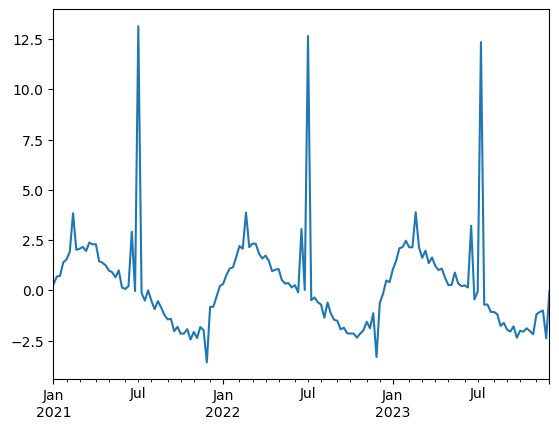

In [16]:
full_data['target'].plot()